# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [7]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

 
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Timing code (contextmanager)

(borrowed from https://stackoverflow.com/questions/7370801/measure-time-elapsed-in-python)

In [11]:
from contextlib import contextmanager
from timeit import default_timer

@contextmanager
def elapsed_timer():
    start = default_timer()
    elapser = lambda: default_timer() - start
    yield lambda: elapser()
    end = default_timer()
    elapser = lambda: end-start
    


In [102]:
with elapsed_timer() as my_timer:
    sum = 0
    for x in range(1000000):
        sum += x
    print(my_timer())
    for x in range(1000000):
        sum += x
    print(my_timer())

0.11968400000478141
0.23295649999636225


####  You might want to go investigate how they work

**What I found online**

In any programming language, the usage of resources like file operations or database connections is very common. But these resources are limited in supply. Therefore, the main problem lies in making sure to release these resources after usage. If they are not released then it will lead to resource leakage and may cause the system to either slow down or crash. It would be very helpful if user have a mechanism for the automatic setup and teardown of resources.In Python, it can be achieved by the usage of context managers which facilitate the proper handling of resources

**To my understanding**

Context Manager is a way to manage resource in you laptop. You can call it from the library contextlib and then use it with the key word "with". 

The format is: 
with (built-in function) as (variable name):
    sum = 0
    for x in range(1000000):
        sum += x
    print((variable name))
    for x in range(1000000):
        sum += x
    print((variable name))
    
where the built-in function can be many different functions where you manage time, memory, etc. 

# Install scitime

In [2]:
!pip install scitime

**I came to this part the last so let's use this package to compare the estimate run time of sgd_clf with its actual run time.** 

sgd_clf.fit took 142.129 secs

Let's see how long does scitime guesses. 

In [13]:
from sklearn.linear_model import SGDClassifier
import time
from scitime import Estimator

# example for rf regressor
estimator = Estimator(meta_algo='RF', verbose=3)
sgd_clf_scitime_test = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# run the estimation
estimation, lower_bound, upper_bound = estimator._estimate(sgd_clf_scitime_test, X_train, y_train)


print("The 95% confidence interval is: " + str(lower_bound) + "-" + str(upper_bound))

KeyError: 'SGDClassifier'

Oops this doesn't work because scitime does not support SGDClassifier.

Let's try SVC.

Below, svm_clf.fit took 31.488 secs to fit 4000 observations.

In [15]:
from sklearn.svm import SVC

# example for rf regressor
estimator = Estimator(meta_algo='RF', verbose=0)
svm_clf_scitime = SVC(gamma="auto", random_state=42)

# run the estimation
estimation, lower_bound, upper_bound = estimator.time(svm_clf_scitime, X_train[:4000], y_train[:4000])

print("The 95% confidence interval is: " + str(lower_bound) + "-" + str(upper_bound))

The 95% confidence interval is: 0.0017998039722442627-0.2910521030426025


Does this mean that it predicts that it will take from 0.001 second to 0.1 to 29 seconds rouughly? 

Because if it does, it's pretty close to the actual time (31 seconds). 

This package is only useful if your algo is fitting a really large training dataset because our 95 confidence interval is super wide. Overall, this is a cool package that can become handy in my independent study. 

# MNIST

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [8]:
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
some_digit = X[0]
X_train.shape

(60000, 784)

In [10]:
y_train.shape

(60000,)

# Multiclass classification

Starting Out

- Note the timing code near the top and the example of how to use it. This is what Python calls a "context manager." It's a good trick and you might want to go investigate how they work.
- Observe that the code is using "svm_clf.fit(X_train[:1000], y_train[:1000])" for training some models. Make sure you understand what that means and consider why things might have been done that way.
- Further down, find the place where the code is fitting an SGDClassifier to the entire training set for MNIST. See how long that takes on your machine.
- Wrap the training for the SVC and OneVsRestClassifiers in timing constructs so you can see how long they take. Then conduct some experiments in which you try successively larger amounts of training data, doubling the size a few times to get a sense of the underlying complexity. You probably want to set up these experiments so they complete without interaction and then run them while you go read your book (or take a long nap :-).

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

### SVM_clf 1k

In [19]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
with elapsed_timer() as sgd_timer:
    svm_clf.fit(X_train[:1000], y_train[:1000]) 
print(f"svm_clf.fit took {sgd_timer():.3f} secs to fit 1000 observations")

svm_clf.predict([some_digit])


svm_clf.fit took 1.871 secs to fit 1000 observations


array([5], dtype=uint8)

**Why things might have been done that way**

Note: You are only using the first 1000 observations to fit the svm for 2 reasons (in my opinion):

- You might want to save the other 5k for dev dataset
- It takes much less time

### SVM_clf 2k

In [21]:
with elapsed_timer() as sgd_timer:
    svm_clf.fit(X_train[:2000], y_train[:2000]) 
print(f"svm_clf.fit took {sgd_timer():.3f} secs to fit 2000 observations")

svm_clf.fit took 7.587 secs to fit 2000 observations


### SVM_clf 4k

In [22]:
with elapsed_timer() as sgd_timer:
    svm_clf.fit(X_train[:4000], y_train[:4000]) 
print(f"svm_clf.fit took {sgd_timer():.3f} secs to fit 4000 observations")

svm_clf.fit took 31.488 secs to fit 4000 observations


In [77]:
import pandas as pd

d = {'Number_of_obs': [1000, 2000, 4000], 'Time_taken': [1.871, 7.587, 31.488]}
SVM_timer_df = pd.DataFrame(data=d)
SVM_timer_df

,Number_of_obs,Time_taken
0,1000,1.871
1,2000,7.587
2,4000,31.488


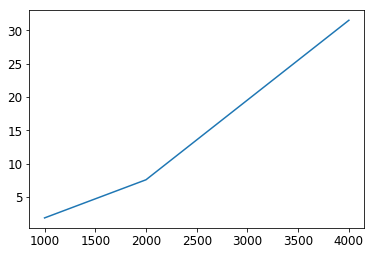

In [41]:
plt.plot(SGD_timer_df['Number_of_obs'], SGD_timer_df['Time_taken'])

**Ok we can kinda see that the complexity of SVC is cubic**

### OVR_clf 1k

In [24]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))

with elapsed_timer() as ovr_timer:
    ovr_clf.fit(X_train[:1000], y_train[:1000])
print(f"ovr_clf.fit took {ovr_timer():.3f} secs to fit 1000 observations")

ovr_clf.predict([some_digit])

ovr_clf.fit took 10.335 secs to fit 1000 observations


array([5], dtype=uint8)

### OVR_clf 2k

In [25]:
with elapsed_timer() as ovr_timer:
    ovr_clf.fit(X_train[:2000], y_train[:2000])
print(f"ovr_clf.fit took {ovr_timer():.3f} secs to fit 2000 observations")

ovr_clf.fit took 39.693 secs to fit 2000 observations


### OVR_clf 4k

In [30]:
with elapsed_timer() as ovr_timer:
    ovr_clf.fit(X_train[:4000], y_train[:4000])
print(f"ovr_clf.fit took {ovr_timer():.3f} secs to fit 4000 observations")

ovr_clf.fit took 155.305 secs to fit 1000 observations


In [36]:
d_ovr = {'Number_of_obs': [1000, 2000, 4000], 'Time_taken': [10.335, 39.693, 155.305 ]}
OVR_timer_df = pd.DataFrame(data=d_ovr)
OVR_timer_df

,Number_of_obs,Time_taken
0,1000,10.335
1,2000,39.693
2,4000,155.305


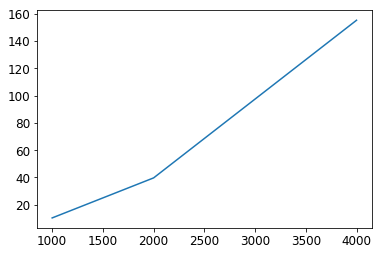

In [38]:
plt.plot(OVR_timer_df['Number_of_obs'], OVR_timer_df['Time_taken'])

**OneVsRestClassifier has the complexity of square**

In [33]:
len(ovr_clf.estimators_)

10

### Here we are fitting an SGDClassifier to the entire training set for MNIST. See how long that takes on your machine.

In [42]:
with elapsed_timer() as sgd_timer:
    sgd_clf.fit(X_train, y_train)
print(f"sgd_clf.fit took {sgd_timer():.3f} secs")
sgd_clf.predict([some_digit])

sgd_clf.fit took 142.129 secs


array([5], dtype=uint8)

- It takes more than 2 minutes for SGDClassifier to fit the whole train dataset of 50k observations

In [43]:
sgd_clf.decision_function([some_digit])

array([[-15955.22627845, -38080.96296175, -13326.66694897,
           573.52692379, -17680.6846644 ,   2412.53175101,
        -25526.86498156, -12290.15704709,  -7946.05205023,
        -10631.35888549]])

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8489802 , 0.87129356, 0.86988048])

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.89707059, 0.8960948 , 0.90693604])

In [48]:
from sklearn.model_selection import cross_val_predict

with elapsed_timer() as cv_predict:

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

print(f"cross_val_predict took {cv_predict():.3f} secs")

KeyboardInterrupt: 

In [ ]:
with elapsed_timer() as cv_predict:

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

print(f"cross_val_predict took {cv_predict():.3f} secs")

## Speeding Things Up, pt. 1

Consider the image on p. 199 of the book (or find the same in the notebook for chapter 7). This suggests that maybe we could train and predict on a smaller image and still do pretty well. Begin by just removing pixels around the edges of the image - how many is up to you. Hint: reshape the image from (784,) to (28, 28) and then use Numpy slicing (that's the : operator) to do this, then reshape back to one dimension. Remember to do the same thing when you predict!

**Let's reshape our dataset in a totally differetn dataset (for safety)**

In [1]:
X_train.ndim

NameError: name 'X_train' is not defined

In [53]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
X_train.shape

(60000, 784)

**hum let's try something with the first 4 obs**

In [56]:
X_train_experiment = X_train[:4]
X_train_experiment.shape

(4, 784)

In [78]:
y_train_experiment = y_train[:4]
y_train_experiment.shape

(4,)

In [57]:
len(X_train_experiment)

4

In [58]:
for i in range (len(X_train_experiment)): 
    X_train_experiment[i] = np.reshape(X_train_experiment[i], (28,28))
    
X_train_experiment.ndim

ValueError: could not broadcast input array from shape (28,28) into shape (784)

**Hum does not really work. Let's try take that row out, reshape it and then put it back in a different narray.**
**And this time, let's work with python array**

In [74]:
X_train_3d = []

for i in range (len(X_train_experiment)): 
    one_digit = X_train_experiment[i]
    one_digit = one_digit.reshape(28,28)
    X_train_3d.append(one_digit)
    
len(X_train_3d)
    

4

In [75]:
print(len(X_train_3d[0]))
print(len(X_train_3d[0][0]))

28
28


Ok so it seems like we are having an array of arrays of arrays

**Let's say we only want 18 pixels in the middle**

In [76]:
for i in range (len(X_train_3d)): 
    X_train_3d[i] = X_train_3d[i][5:23,5:23]
    
print(len(X_train_3d))
print(len(X_train_3d[0]))
print(len(X_train_3d[0][0]))

4
18
18


In [91]:
X_train_experiment_final = np.array([])

for i in range (len(X_train_3d)): 
    one_digit = X_train_3d[i]
    omgiwanttosleep = np.array(one_digit)
    omgiwanttosleep = np.reshape(omgiwanttosleep, 324)
    X_train_experiment_final = np.concatenate((X_train_experiment_final,omgiwanttosleep))
    
    
print(X_train_experiment_final.shape)
print(X_train_experiment_final.ndim)

(1296,)
1


In [92]:
X_train_experiment_final

array([0., 0., 0., ..., 0., 0., 0.])

In [93]:
X_train_experiment_final = np.reshape(X_train_experiment_final, (len(X_train_3d), 324))

X_train_experiment_final.ndim


2

In [95]:
X_train_experiment_final.shape

(4, 324)

In [96]:
import sys

np.set_printoptions(threshold=sys.maxsize)

print(X_train_experiment_final)

[[  0.   0.   0.   0.   0.   0.   0.   3.  18.  18.  18. 126. 136. 175.
   26. 166. 255. 247.   0.   0.   0.  30.  36.  94. 154. 170. 253. 253.
  253. 253. 253. 225. 172. 253. 242. 195.   0.   0.  49. 238. 253. 253.
  253. 253. 253. 253. 253. 253. 251.  93.  82.  82.  56.  39.   0.   0.
   18. 219. 253. 253. 253. 253. 253. 198. 182. 247. 241.   0.   0.   0.
    0.   0.   0.   0.   0.  80. 156. 107. 253. 253. 205.  11.   0.  43.
  154.   0.   0.   0.   0.   0.   0.   0.   0.   0.  14.   1. 154. 253.
   90.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0. 139. 253. 190.   2.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.  11. 190. 253.  70.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  35. 241. 225.
  160. 108.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.  81. 240. 253. 253. 119.  25.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.  45. 186. 253. 253. 150.  2

Ok so it seems like we get what we need

In [97]:
print(y_train_experiment.shape)
print(y_train_experiment.ndim)

(4,)
1


In [98]:
y_train_experiment

array([5, 0, 4, 1], dtype=uint8)

In [102]:
sgd_clf_18pixel_experiment = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

with elapsed_timer() as sgd_timer_experiment:
    sgd_clf_18pixel_experiment.fit(X_train_experiment_final, y_train_experiment)
print(f"sgd_clf.fit took {sgd_timer_experiment():.3f} secs to fit 4 obs")


sgd_clf.fit took 0.535 secs to fit 4 obs


Modify some_digit so we can test with it 

In [103]:
# Reshape it into 28x28
some_digit = np.reshape(some_digit, (28,28))

# Slice out only 18 pixels in the middle  
some_digit = some_digit[5:23,5:23]

# put them back as 1 array of len 324
some_digit = np.reshape(some_digit, 324)

print(some_digit.ndim)
print(some_digit.shape)

1
(324,)


In [104]:
sgd_clf_18pixel_experiment.predict([some_digit])

array([5], dtype=uint8)

Ok it kinda works. Let's try this on the whole train data set

### Try it on the actual train data set

In [111]:
X_train_3d_real = []

for i in range (len(X_train)): 
    one_digit = X_train[i]
    one_digit = one_digit.reshape(28,28)
    X_train_3d_real.append(one_digit)
    
print(len(X_train_3d_real))
print(len(X_train_3d_real[4]))
print(len(X_train_3d_real[4][4]))

60000
28
28


Perfect, exactly what I want 

Let's do some slicing. Since we still have a lot of 0s on the outside, let's slice more this time. Only takes 16 pixels in the middle.

In [112]:
for i in range (len(X_train_3d_real)): 
    X_train_3d_real[i] = X_train_3d_real[i][6:22,6:22]
    
print(len(X_train_3d_real))
print(len(X_train_3d_real[0]))
print(len(X_train_3d_real[0][0]))

60000
16
16


Just checking

In [113]:
one_digit = X_train_3d_real[i]
print("SHould be 16:" + str(len(one_digit)))
print("SHould be 16:" + str(len(one_digit[1])))

omgiwanttosleep = np.array(one_digit)
print(omgiwanttosleep.ndim)
print(omgiwanttosleep.shape)

SHould be 16:16
SHould be 16:16
2
(16, 16)


In [114]:
X_train_final = np.array([])

for i in range (len(X_train_3d_real)): 
    one_digit = X_train_3d_real[i]
    omgiwanttosleep = np.array(one_digit)
    omgiwanttosleep = np.reshape(omgiwanttosleep, 256)
    X_train_final = np.concatenate((X_train_final,omgiwanttosleep))
    
    
print(X_train_experiment_final.shape)
print(X_train_experiment_final.ndim)

KeyboardInterrupt: 

In [115]:
print(X_train_final.shape)
print(X_train_final.ndim)

(9949440,)
1


Ok this is not working. It was 10 minutes before I interupted the kernel so for the cell to finish, it's too expensive. It takes too long to stack each obs on each other

In [ ]:
sgd_clf_16pixel = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

with elapsed_timer() as sgd_timer:
    sgd_clf_16pixel.fit(X_train_final, y_train)
print(f"sgd_clf.fit took {sgd_timer():.3f} secs to fit 60k obs")



## Speeding Things Up, pt. 1: importance values of pixels

In [9]:
X_train_2, y_train_2 = X[:60000], y[:60000]

print(X_train_2.shape)
print(y_train_2.shape)

(60000, 784)
(60000,)


Let's use random forest to measure the importance of each feature

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs=-1)

with elapsed_timer() as rndclf_timer:
    rnd_clf.fit(X_train_2, y_train_2)
print(f"rnd_clf.fit took {rndclf_timer():.3f} secs to fit 60k obs")


for name, score in zip(mnist["feature_names"], rnd_clf.feature_importances_):       
    print(name, score)


rnd_clf.fit took 59.130 secs to fit 60k obs
pixel1 0.0
pixel2 0.0
pixel3 0.0
pixel4 0.0
pixel5 0.0
pixel6 0.0
pixel7 0.0
pixel8 0.0
pixel9 0.0
pixel10 0.0
pixel11 0.0
pixel12 0.0
pixel13 7.292368168820393e-08
pixel14 2.6900974017708236e-07
pixel15 2.8482488748219666e-07
pixel16 7.272845049903546e-08
pixel17 0.0
pixel18 0.0
pixel19 0.0
pixel20 0.0
pixel21 0.0
pixel22 0.0
pixel23 0.0
pixel24 0.0
pixel25 0.0
pixel26 0.0
pixel27 0.0
pixel28 0.0
pixel29 0.0
pixel30 0.0
pixel31 0.0
pixel32 0.0
pixel33 0.0
pixel34 0.0
pixel35 6.938858001962294e-07
pixel36 1.7930511239868788e-06
pixel37 1.1930973740222567e-06
pixel38 1.5818930508303875e-06
pixel39 6.840324761209703e-07
pixel40 2.6159621977341806e-06
pixel41 2.0410864192165205e-06
pixel42 1.804472371249874e-06
pixel43 3.6472157142120734e-06
pixel44 3.814401004327182e-06
pixel45 3.4474508064894157e-06
pixel46 4.388782059067406e-06
pixel47 1.2089922263523218e-06
pixel48 1.2191609610072975e-06
pixel49 1.4450403304741035e-06
pixel50 8.8115040982373

Saving figure mnist_feature_importance_plot


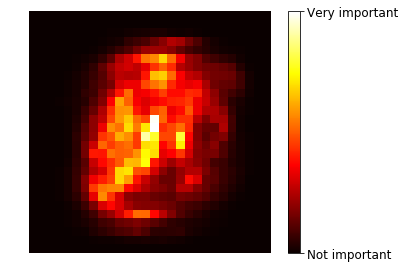

In [15]:
# some code from the book 

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")
    
    
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

Ok so looks like the importance really starts to increase from line 4,5ish, which mean we should look at pixels from around ~130-150. Let try some different threseholds to see which one works the best. We expect to see around 256 pixels pull through. 

In [21]:
a = np.array(mnist["feature_names"])
b = rnd_clf.feature_importances_

threshold_point001 = a[(b > 0.001)]
threshold_point002 = a[(b > 0.002)]
threshold_point003 = a[(b > 0.003)]

print("Threshold of 0.001, we will keep " + str(len(threshold_point001)) + " features")
print("Threshold of 0.002 ,we will keep " + str(len(threshold_point002)) + " features")
print("Threshold of 0.003, we will keep " + str(len(threshold_point003)) + " features")

Threshold of 0.001, we will keep 301 features
Threshold of 0.002 ,we will keep 196 features
Threshold of 0.003, we will keep 141 features


Ok let's go with 0.002 then. 200 features seem sufficient enough. 

In [24]:
for i in range (len(X_train_2)):
    one_digit = X_train_2[i]
    one_digit = one_digit[b in threshold_point002]
    X_train_2[i] = one_digit
    

C:\Users\minhv\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: could not broadcast input array from shape (0,784) into shape (784)

In [34]:
boolean_pixels = []

for i in range (len(a)):
    if a[i] in threshold_point002:
        boolean_pixels.append(True)
    else:
        boolean_pixels.append(False)

boolean_pixels = np.array(boolean_pixels)

print("Len of the boolean_pixels array is: " + str(len(boolean_pixels)))

Len of the boolean_pixels array is: 784


We will go through one by one digit.

In [35]:
X_train_2_final = np.array

for i in range (len(X_train_2)):
    one_digit = X_train_2[i]
    one_digit = one_digit[boolean_pixels]
    X_train_2[i] = one_digit
    
X_train_2.shape

ValueError: could not broadcast input array from shape (196) into shape (784)

In the end, we want a 2-d array shape of (60,000, 196). So let's initialize that array first, and then fill it with filtered pixels from X_train_2. 

In [37]:
X_train_2_final = np.arange(60000*196).reshape(60000,196)

for i in range (len(X_train_2)):
    one_digit = X_train_2[i]
    one_digit = one_digit[boolean_pixels]
    X_train_2_final[i] = one_digit
    
X_train_2_final[3]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  96, 244,   0,   0,   0,   0,
         0,   0,   0, 127, 251, 251,   0,   0,   0,   0,   0,   0,  68,
       236, 251, 211,  31,   0,   0,   0,   0,   0,   0,  60, 228, 251,
       251,  94,   0,   0,   0,   0,   0,   0,   0, 155, 253, 253, 189,
         0,   0,   0,   0,   0,   0,   0,   0,  20, 253, 251, 235,  66,
         0,   0,   0,   0,   0,   0,   0,   0,  32, 205, 253, 251, 126,
         0,   0,   0,   0,   0,   0,   0,   0,   0, 104, 251, 253, 184,
        15,   0,   0,   0,   0,   0,   0,  80, 240, 251, 193,  23,   0,
         0,   0,   0,   0,   0,  32, 253, 253, 253, 159,   0,   0,   0,
         0,   0,   0,   0, 151, 251, 251, 251,  39,   0,   0,   0,   0,
         0,   0,  48, 221, 251, 251, 172,   0,   0,   0,   0,   0,   0,
         0, 234, 251, 251, 196,  12,   0,   0,   0,   0,   0, 253, 251,
       251,  89,   0,   0,   0,   0, 159, 255, 253, 253,  31,   

In [38]:
X_train_2_final.shape

(60000, 196)

Alrighty, we are finally ready for this. 

In [39]:
sgd_clf_feature_importance = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

with elapsed_timer() as sgd_timer:
    sgd_clf_feature_importance.fit(X_train_2_final, y_train)
print(f"sgd_clf.fit took {sgd_timer():.3f} secs to fit 60k obs, each with only 196 features")


sgd_clf.fit took 50.892 secs to fit 60k obs, each with only 196 features


**Above it takes 142s to fit a sgd classifier into the whole train dataset, which consists 784 features each observation.**

**By reducing the number of features down to 196, it now only takes 50s.**

### Evaluation for Random Forrest

An example of a confusion matrix for multiclass classifier.

![](datasets/Lab4/Multi_Class_Classification.png)

In [42]:
X_test_196_pixels = np.arange(10000*196).reshape(10000,196)

for i in range (len(X_test)):
    one_digit = X_test[i]
    one_digit = one_digit[boolean_pixels]
    X_test_196_pixels[i] = one_digit
    
X_test_196_pixels.shape

(10000, 196)

In [43]:
y_test_feature_importance_pred = sgd_clf_feature_importance.predict(X_test_196_pixels)

y_test_feature_importance_pred.shape

(10000,)

In [45]:
(unique, counts) = np.unique(y_test_feature_importance_pred, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

[[   0 1008]
 [   1 1113]
 [   2  783]
 [   3  473]
 [   4  798]
 [   5 1373]
 [   6 1133]
 [   7  591]
 [   8  932]
 [   9 1796]]


Ok so there are 10 distinct classes (0 to 9). We will want to have a 2d array of shape 10x10 for the confusion matrix. 

Go into the y_test array, check each digit to get the index to see the number we predict in y_test_feature_importance_pred

(We can also do this with 10 different OneVsRest Classifier to compute Precision and Recall for 10 digits, but let's do it this way this time so we will learn something new) 

In [51]:
confusion_matrix = np.zeros((10,10))

for i in range (len(y_test)):
    confusion_matrix[y_test[i]][y_test_feature_importance_pred[i]] += 1
    
confusion_matrix = confusion_matrix.astype(int)
confusion_matrix

array([[ 913,    0,    1,    0,    0,   25,   24,    0,    4,   13],
       [   0, 1072,    2,    0,    3,    5,    6,    1,   45,    1],
       [  13,    9,  743,   11,   23,   31,   47,    1,   96,   58],
       [  21,    4,   15,  454,    5,  368,   17,    3,   54,   69],
       [   2,    1,    1,    1,  705,    9,   42,    0,    8,  213],
       [  17,    3,    3,    1,    8,  758,   48,    1,   15,   38],
       [  22,    2,    5,    0,    9,    9,  902,    0,    6,    3],
       [   5,   11,    9,    1,   20,   10,    4,  582,   32,  354],
       [   9,    5,    4,    5,   13,  135,   39,    1,  668,   95],
       [   6,    6,    0,    0,   12,   23,    4,    2,    4,  952]])

Wowla perfect. Let's compute some numbers

Since we have pretty even numbers of 10 digits, accuracy can be helpful. 

In [54]:
FI_accuracy = 0

for i in range (len(confusion_matrix)):
    FI_accuracy += confusion_matrix[i][i]

FI_accuracy /= 10000

print("Using RandomForrestClassifier to measure the importance of features, we get the accuracy of: " + str(FI_accuracy))

Using RandomForrestClassifier to measure the importance of features, we get the accuracy of: 0.7749


**Precision: the accuracy of the positive predictions**

Compute FP

In [56]:
FP = [0] * 10  

for i in range (len(FP)):
    for j in range (len(FP)):
        if i != j:
            FP[i] += confusion_matrix[j][i]

FP  

[95, 41, 40, 19, 93, 615, 231, 9, 264, 844]

Compute TP

In [57]:
TP = [0] * 10  

for i in range (len(FP)):
    TP[i] += confusion_matrix[i][i]

TP 

[913, 1072, 743, 454, 705, 758, 902, 582, 668, 952]

Compute Precision: 

In [58]:
precision = [0] * 10

for i in range (len(precision)):
    precision[i] = TP[i] / (TP[i] + FP[i])

precision

[0.9057539682539683,
 0.963162623539982,
 0.9489144316730523,
 0.959830866807611,
 0.8834586466165414,
 0.5520757465404225,
 0.7961165048543689,
 0.9847715736040609,
 0.7167381974248928,
 0.5300668151447662]

Ok there we have it the precision of each digit (not doing so great with digit 9)

**Recall: this is the ratio of positive instances that are correctly detected by the classifier**


In [59]:
FN = [0] * 10

for i in range (len(FP)):
    for j in range (len(FP)):
        if i != j:
            FN[i] += confusion_matrix[i][j]

FN

[67, 63, 289, 556, 277, 134, 56, 446, 306, 57]

In [60]:
recall = [0] * 10

for i in range (len(recall)):
    recall[i] = TP[i] / (TP[i] + FN[i])

recall

[0.9316326530612244,
 0.9444933920704845,
 0.7199612403100775,
 0.4495049504950495,
 0.7179226069246436,
 0.8497757847533632,
 0.941544885177453,
 0.566147859922179,
 0.6858316221765913,
 0.9435084241823588]

We can clearly see the trade off between precision and recall.

## Speeding Things Up, pt. 2

Use PCA to reduce the dimensionality of the space. Directly compare this approach with your results in part 1 by choosing a reduced input space of the same size you experimented with there. Then also try the reduction that preserves just more than 80% of the variance and see how that performs in terms of accuracy.

#### So above we decide to keep 196 pixels of our training dataset. Let's start off by directly choosing 196 as the number of components. 

In [64]:
from sklearn.decomposition import PCA

pca_196 = PCA(n_components = 196)

with elapsed_timer() as pca196_timer:
    X_train_pca_reduced_196 = pca_196.fit_transform(X_train)
print(f"pca.fit_transform took {pca196_timer():.3f} secs to fit transform 60k obs")


pca.fit_transform took 5.560 secs to fit transform 60k obs


In [66]:
X_train_pca_reduced_196.shape

(60000, 196)

In [68]:
print(pca_196.explained_variance_ratio_)

[0.09704664 0.07095924 0.06169089 0.05389419 0.04868797 0.04312231
 0.0327193  0.02883895 0.02762029 0.02357001 0.0210919  0.02022991
 0.01715818 0.01692111 0.01578641 0.01482953 0.01324561 0.01276897
 0.01187263 0.01152684 0.01066166 0.01006713 0.00953573 0.00912544
 0.00883405 0.00839319 0.00812579 0.00786366 0.00744733 0.00690859
 0.00658094 0.00648148 0.00602615 0.00586582 0.00570021 0.00543628
 0.00505786 0.00487859 0.00481429 0.00472266 0.00456747 0.00444836
 0.00418501 0.00398215 0.00384975 0.00375103 0.00362009 0.00351591
 0.00340058 0.00321874 0.00319017 0.00312805 0.00295983 0.00288955
 0.0028413  0.00271436 0.00269521 0.00258473 0.00253771 0.00244781
 0.00240506 0.00239263 0.00230408 0.00221532 0.00213721 0.00207225
 0.00203043 0.00196783 0.00192853 0.00188632 0.00186977 0.00181083
 0.00177562 0.00174898 0.00165758 0.00163894 0.00161462 0.00155116
 0.00147613 0.00143176 0.00142094 0.00141153 0.00140174 0.00135736
 0.00133847 0.00132396 0.00130157 0.00125873 0.00122828 0.0012

In [67]:
sgd_clf_pca196 = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

with elapsed_timer() as sgd_pca196_timer:
    sgd_clf_pca196.fit(X_train_pca_reduced_196, y_train)
print(f"sgd_clf_pca196.fit took {sgd_pca196_timer():.3f} secs to fit 60k obs, each with only 196 features")


sgd_clf_pca196.fit took 33.137 secs to fit 60k obs, each with only 196 features


In [69]:
X_test_pca_reduced_196 = pca_196.transform(X_test)
X_test_pca_reduced_196.shape

(10000, 196)

In [70]:
y_test_pca196_pred = sgd_clf_pca196.predict(X_test_pca_reduced_196)

y_test_pca196_pred.shape

(10000,)

### Evaluation for PCA196

In [71]:
confusion_matrix_pca196 = np.zeros((10,10))

for i in range (len(y_test)):
    confusion_matrix_pca196[y_test[i]][y_test_pca196_pred[i]] += 1
    
confusion_matrix_pca196 = confusion_matrix_pca196.astype(int)
confusion_matrix_pca196

array([[ 946,    0,    6,    1,    0,    7,   13,    4,    1,    2],
       [   0, 1087,    6,    7,    0,   10,    7,    2,   15,    1],
       [   6,    9,  935,   13,    3,    0,   17,   25,   21,    3],
       [   2,    0,   26,  919,    1,   18,    8,   10,   15,   11],
       [   1,    0,    7,    0,  870,    2,   16,   15,   10,   61],
       [   8,    1,    9,   49,   12,  726,   31,   13,   27,   16],
       [   8,    1,   11,    0,    6,   19,  909,    0,    4,    0],
       [   3,    9,   17,    6,    5,    3,    1,  944,    0,   40],
       [   8,    6,   21,   21,    7,   25,   31,   25,  811,   19],
       [   7,    5,    3,   12,   37,    6,    0,   41,   15,  883]])

Compute Accuracy

In [73]:
pca196_accuracy = 0

for i in range (len(confusion_matrix_pca196)):
    pca196_accuracy += confusion_matrix_pca196[i][i]

pca196_accuracy /= 10000

print("Using PCA to reduce the dimension down to 196, we get the accuracy of: " + str(pca196_accuracy))

Using PCA to reduce the dimension down to 196, we get the accuracy of: 0.903


Wow impressive. We get much higher accuracy. Let's check precision and recall

In [74]:
TP_pca196 = [0] * 10  

for i in range (len(TP_pca196)):
    TP_pca196[i] += confusion_matrix_pca196[i][i]

TP_pca196 

[946, 1087, 935, 919, 870, 726, 909, 944, 811, 883]

Compute FP

In [75]:
FP_pca196 = [0] * 10  

for i in range (len(FP_pca196)):
    for j in range (len(FP_pca196)):
        if i != j:
            FP_pca196[i] += confusion_matrix_pca196[j][i]

FP_pca196  

[43, 31, 106, 109, 71, 90, 124, 135, 108, 153]

In [76]:
precision_pca196 = [0] * 10

for i in range (len(precision_pca196)):
    precision_pca196[i] = TP_pca196[i] / (TP_pca196[i] + FP_pca196[i])

precision_pca196

[0.9565217391304348,
 0.9722719141323792,
 0.8981748318924111,
 0.8939688715953308,
 0.924548352816153,
 0.8897058823529411,
 0.8799612778315585,
 0.8748841519925857,
 0.8824809575625681,
 0.8523166023166023]

In [78]:
import pandas as pd

d_precision_pcaVSrdnforrest = {'RandomForrest': precision, 'PCA196': precision_pca196}
pd.DataFrame(data = d_precision_pcaVSrdnforrest)

,RandomForrest,PCA196
0,0.905754,0.956522
1,0.963163,0.972272
2,0.948914,0.898175
3,0.959831,0.893969
4,0.883459,0.924548
5,0.552076,0.889706
6,0.796117,0.879961
7,0.984772,0.874884
8,0.716738,0.882481
9,0.530067,0.852317


Overall, we do much better with pca196

Compute Recall for pca196

In [79]:
FN_pca196 = [0] * 10

for i in range (len(FN_pca196)):
    for j in range (len(FN_pca196)):
        if i != j:
            FN_pca196[i] += confusion_matrix[i][j]

FN_pca196

[67, 63, 289, 556, 277, 134, 56, 446, 306, 57]

In [80]:
recall_pca196 = [0] * 10

for i in range (len(recall_pca196)):
    recall_pca196[i] = TP_pca196[i] / (TP_pca196[i] + FN_pca196[i])

recall_pca196

[0.9338598223099703,
 0.9452173913043478,
 0.7638888888888888,
 0.6230508474576271,
 0.7585004359197908,
 0.8441860465116279,
 0.9419689119170984,
 0.679136690647482,
 0.7260519247985676,
 0.9393617021276596]

In [81]:
d_recall_pcaVSrdnforrest = {'RandomForrest': recall, 'PCA196': recall_pca196}
pd.DataFrame(data = d_recall_pcaVSrdnforrest)

,RandomForrest,PCA196
0,0.931633,0.933860
1,0.944493,0.945217
2,0.719961,0.763889
3,0.449505,0.623051
4,0.717923,0.758500
5,0.849776,0.844186
6,0.941545,0.941969
7,0.566148,0.679137
8,0.685832,0.726052
9,0.943508,0.939362


We still somewhat do better 

### Then also try the reduction that preserves just more than 80% of the variance and see how that performs in terms of accuracy.

In [85]:
pca_80per = PCA()
pca_80per.fit(X_train)
cumsum = np.cumsum(pca_80per.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1

d

44

Saving figure explained_variance_plot


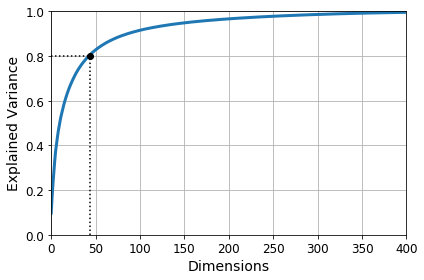

In [84]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.8], "k:")
plt.plot([0, d], [0.8, 0.8], "k:")
plt.plot(d, 0.8, "ko")

plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

Ok so to preserve just more than 80% of the variance, we only need to keep 44 pixels.

In [87]:
pca_80per = PCA(n_components = 0.8)

X_train_80per = pca_80per.fit_transform(X_train)

X_train_80per.shape

(60000, 44)

In [88]:
np.sum(pca_80per.explained_variance_ratio_)

0.8032907553836799

In [89]:
sgd_clf_pca80per = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

with elapsed_timer() as sgd_pca80per_timer:
    sgd_clf_pca80per.fit(X_train_80per, y_train)
print(f"sgd_pca80per_timer.fit took {sgd_pca80per_timer():.3f} secs to fit 60k obs, each with only 44 features")

sgd_pca80per_timer.fit took 12.665 secs to fit 60k obs, each with only 44 features


In [90]:
X_test_pca_80per = pca_80per.transform(X_test)
X_test_pca_80per.shape

(10000, 44)

In [91]:
y_test_pca_80per = sgd_clf_pca80per.predict(X_test_pca_80per)

y_test_pca_80per.shape

(10000,)

### Evaluation for pca_80per

In [92]:
confusion_matrix_pca80per = np.zeros((10,10))

for i in range (len(y_test)):
    confusion_matrix_pca80per[y_test[i]][y_test_pca_80per[i]] += 1
    
confusion_matrix_pca80per = confusion_matrix_pca80per.astype(int)
confusion_matrix_pca80per

array([[ 945,    0,    1,    0,    1,   14,   13,    2,    4,    0],
       [   0, 1086,    7,    3,    0,    1,    4,    1,   32,    1],
       [  10,   17,  859,   32,   15,    0,   22,   15,   57,    5],
       [   4,   10,   15,  908,    3,   21,    5,    6,   28,   10],
       [   4,    4,    2,    3,  900,    2,   20,    2,    7,   38],
       [  15,    7,    9,   63,   30,  695,   21,    9,   35,    8],
       [  14,    4,    2,    1,    5,    8,  915,    6,    3,    0],
       [   2,   18,   24,    6,   15,    2,    0,  928,    5,   28],
       [  10,   29,   11,   38,    9,   33,   20,   14,  800,   10],
       [  17,   18,    4,   13,   68,   16,    3,   58,   23,  789]])

Compute TP

In [93]:
TP_pca80per = [0] * 10  

for i in range (len(TP_pca80per)):
    TP_pca80per[i] += confusion_matrix_pca80per[i][i]

TP_pca80per 

[945, 1086, 859, 908, 900, 695, 915, 928, 800, 789]

Compute Accuracy

In [94]:
pca80per_accuracy = np.sum(TP_pca80per) / 10000

print("Using PCA to reduce the dimension down so we can keep just 80 percent of variance, we get the accuracy of: " + str(pca80per_accuracy))

Using PCA to reduce the dimension down so we can keep just 80 percent of variance, we get the accuracy of: 0.8825


We get slightly lower accuracy compared to when we set the number of pixel as 196.

Compute FP

In [95]:
FP_pca80per = [0] * 10  

for i in range (len(FP_pca80per)):
    for j in range (len(FP_pca80per)):
        if i != j:
            FP_pca80per[i] += confusion_matrix_pca80per[j][i]

FP_pca80per  

[76, 107, 75, 159, 146, 97, 108, 113, 194, 100]

Compute Precision

In [96]:
precision_pca80per = [0] * 10

for i in range (len(precision_pca80per)):
    precision_pca80per[i] = TP_pca80per[i] / (TP_pca80per[i] + FP_pca80per[i])

precision_pca80per

[0.9255631733594515,
 0.9103101424979044,
 0.9197002141327623,
 0.8509840674789129,
 0.8604206500956023,
 0.8775252525252525,
 0.8944281524926686,
 0.8914505283381364,
 0.8048289738430584,
 0.8875140607424072]

In [97]:
d_precision_pcaVSrdnforrest_VS_pca80per = {'RandomForrest': precision, 'PCA196': precision_pca196, 'PCA80per': precision_pca80per}
pd.DataFrame(data = d_precision_pcaVSrdnforrest_VS_pca80per)

,RandomForrest,PCA196,PCA80per
0,0.905754,0.956522,0.925563
1,0.963163,0.972272,0.910310
2,0.948914,0.898175,0.919700
3,0.959831,0.893969,0.850984
4,0.883459,0.924548,0.860421
5,0.552076,0.889706,0.877525
6,0.796117,0.879961,0.894428
7,0.984772,0.874884,0.891451
8,0.716738,0.882481,0.804829
9,0.530067,0.852317,0.887514


Overall, 2 PCA methods did not yield that much of a difference in precision. I will not compute recall because we can expect a roughly the same result. 

# End of Lab 4